## Fit AuotoARIMA

In [1]:
import pandas as pd


# List of file paths
file_paths = ['rnd/2013-7/392.csv', 'rnd/2013-8/392.csv', 'rnd/2013-9/392.csv']

# Initialize an empty list to store each DataFrame
dataframes = []

# Loop through each file path, load the data, and append to the list
for file_path in file_paths:
    df = pd.read_csv(file_path, sep=';\t', engine='python')  # Load each file
    dataframes.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
data = pd.concat(dataframes, ignore_index=True)

# Adjusting the timestamp to reflect the correct year and month ("2013-08")

# We will recalculate the timestamp considering that each measurement was taken every 5 minutes starting from August 2013
# Assuming the first record starts at the beginning of August 2013
start_date = "2013-07-01 00:00:00"
start_timestamp = pd.to_datetime(start_date)

# Generating timestamps for each row, assuming 5-minute intervals
timestamps = [start_timestamp + pd.Timedelta(minutes=5*i) for i in range(len(data))]

# Assigning the new timestamps to the dataframe
data['ds'] = timestamps


# Creating the two univariate datasets with the corrected timestamp
memory_usage_dataset_with_corrected_timestamp = data[['ds', 'Memory usage [KB]']].copy()
memory_usage_dataset_with_corrected_timestamp  = memory_usage_dataset_with_corrected_timestamp.rename(columns={'Memory usage [KB]': 'y'})

#Resample to hours
memory_usage_dataset_with_corrected_timestamp['ds'] = pd.to_datetime(memory_usage_dataset_with_corrected_timestamp['ds'])
memory_usage_dataset_with_corrected_timestamp.set_index('ds', inplace=True)
memory_usage_dataset_with_corrected_timestamp = memory_usage_dataset_with_corrected_timestamp.resample('H').mean()

memory_usage_dataset_with_corrected_timestamp = memory_usage_dataset_with_corrected_timestamp.reset_index()


memory_usage_dataset_with_corrected_timestamp['unique_id'] = 'VM392_mem'

memory_usage_dataset_with_corrected_timestamp = memory_usage_dataset_with_corrected_timestamp.tail(7*24) #Select last 7 days of data to make example faster

# Displaying the first few rows of each corrected dataset to verify
memory_usage_dataset_with_corrected_timestamp




,ds,y,unique_id
1934,2013-09-19 14:00:00,6.029543e+06,VM392_mem
1935,2013-09-19 15:00:00,5.734078e+06,VM392_mem
1936,2013-09-19 16:00:00,6.760284e+06,VM392_mem
1937,2013-09-19 17:00:00,6.256036e+06,VM392_mem
1938,2013-09-19 18:00:00,5.653921e+06,VM392_mem
...,...,...,...
2097,2013-09-26 09:00:00,3.837320e+06,VM392_mem
2098,2013-09-26 10:00:00,3.838252e+06,VM392_mem
2099,2013-09-26 11:00:00,3.669548e+06,VM392_mem
2100,2013-09-26 12:00:00,3.927731e+06,VM392_mem


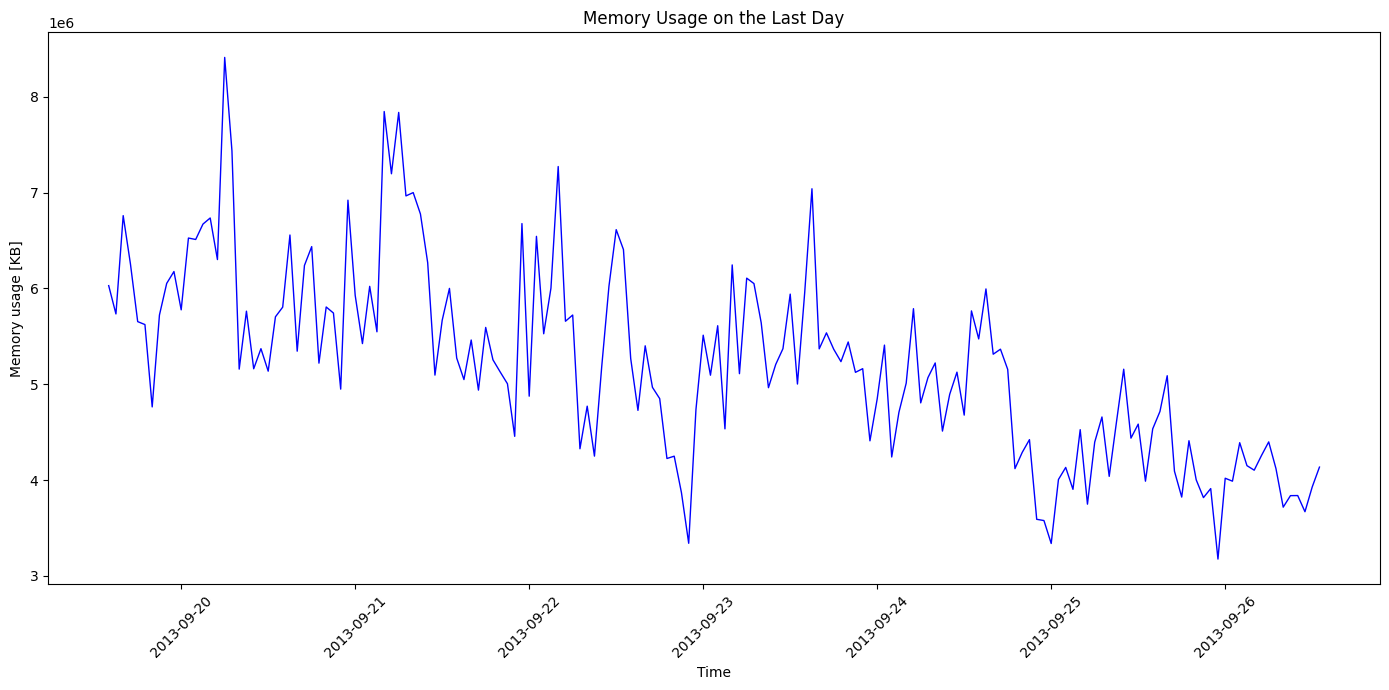

In [2]:
import matplotlib.pyplot as plt

# Plotting the CPU usage data for the last day
plt.figure(figsize=(14, 7))
plt.plot(memory_usage_dataset_with_corrected_timestamp['ds'], memory_usage_dataset_with_corrected_timestamp['y'], color='blue', linewidth=1)
plt.title('Memory Usage on the Last Day')
plt.xlabel('Time')
plt.ylabel('Memory usage [KB]')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [3]:
from statsforecast import StatsForecast



/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
from statsforecast.models import (
    AutoARIMA,
    AutoTheta,
    AutoETS,
    AutoCES,
    SeasonalNaive,
    WindowAverage,
    SeasonalWindowAverage,
    Naive
)

models = [
    AutoARIMA(season_length=24),
    AutoTheta(season_length=24),
    AutoETS(season_length=24),
    AutoCES(season_length=24),
    SeasonalNaive(season_length=24), 
    WindowAverage(window_size=24), 
    SeasonalWindowAverage(window_size=1, season_length=24),
    Naive()
]

sf = StatsForecast( 
    models=models,
    freq='H', 
    n_jobs=-1,
)

#forecasts_df = sf.forecast(df=cpu_usage_dataset_with_corrected_timestamp, h=48, level=[90])
#forecasts_df

In [5]:
#sf.plot(cpu_usage_dataset_with_corrected_timestamp,forecasts_df)


In [6]:
crossvaldation_df = sf.cross_validation(
    df=memory_usage_dataset_with_corrected_timestamp,
    h=24,
    step_size=48,
    n_windows=1
)

/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [7]:
crossvaldation_df

,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,SeasonalNaive,WindowAverage,SeasWA,Naive
unique_id,,,,,,,,,,,
VM392_mem,2013-09-25 14:00:00,2013-09-25 13:00:00,4534507.00,4357104.50,4306348.0,4309824.5,4275757.00,5473332.00,4450781.5,5473332.00,3988315.0
VM392_mem,2013-09-25 15:00:00,2013-09-25 13:00:00,4716259.50,4425932.00,4306348.0,4309824.5,4588914.50,5995056.50,4450781.5,5995056.50,3988315.0
VM392_mem,2013-09-25 16:00:00,2013-09-25 13:00:00,5089087.00,4336047.00,4306348.0,4309824.5,4144359.50,5313715.00,4450781.5,5313715.00,3988315.0
VM392_mem,2013-09-25 17:00:00,2013-09-25 13:00:00,4092706.50,4342959.50,4306348.0,4309824.5,4162486.75,5366111.50,4450781.5,5366111.50,3988315.0
VM392_mem,2013-09-25 18:00:00,2013-09-25 13:00:00,3822407.00,4315143.50,4306348.0,4309824.5,4223410.50,5155264.00,4450781.5,5155264.00,3988315.0
VM392_mem,2013-09-25 19:00:00,2013-09-25 13:00:00,4410541.50,4178472.00,4306348.0,4309824.5,3590228.00,4119270.75,4450781.5,4119270.75,3988315.0
VM392_mem,2013-09-25 20:00:00,2013-09-25 13:00:00,4002296.25,4200789.50,4306348.0,4309824.5,3729516.50,4288441.00,4450781.5,4288441.00,3988315.0
VM392_mem,2013-09-25 21:00:00,2013-09-25 13:00:00,3816814.25,4218382.00,4306348.0,4309824.5,3610742.25,4421793.00,4450781.5,4421793.00,3988315.0
VM392_mem,2013-09-25 22:00:00,2013-09-25 13:00:00,3910953.50,4108691.25,4306348.0,4309824.5,3092712.75,3590321.75,4450781.5,3590321.75,3988315.0


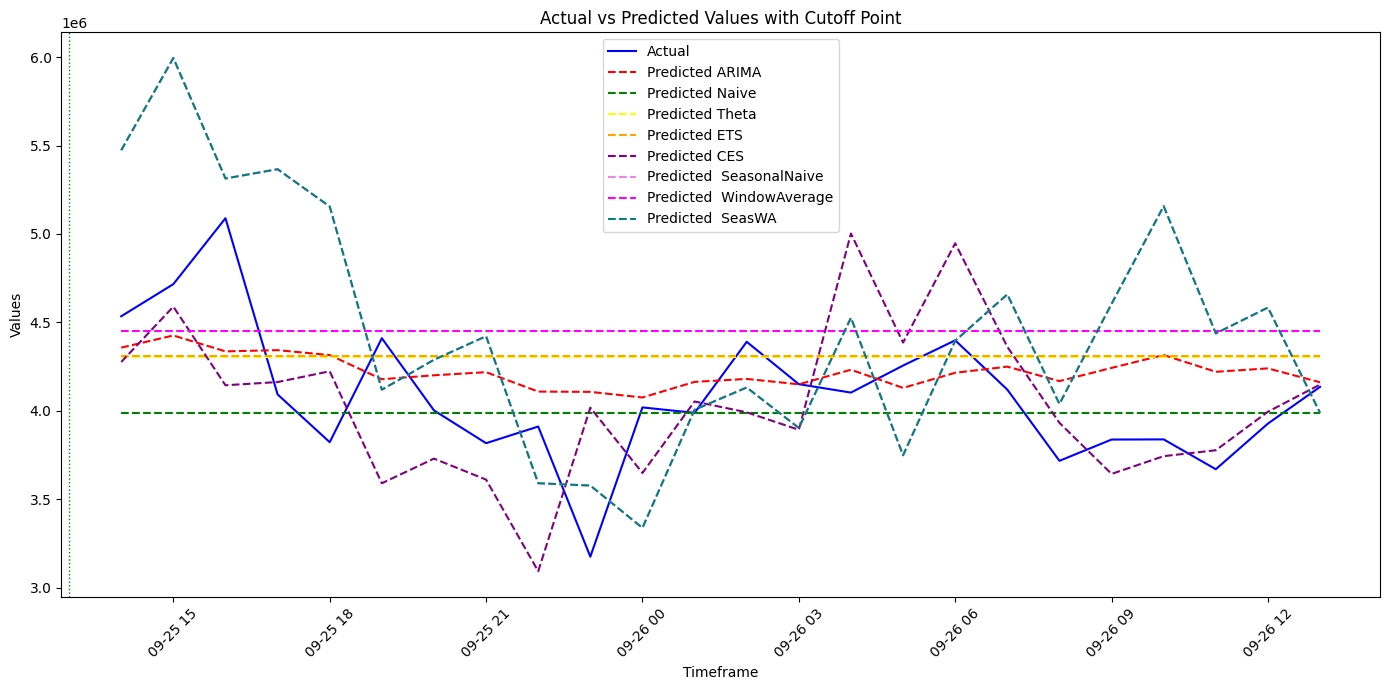

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [9]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

# Initialize and fit the Prophet model
model = Prophet()

model.fit(memory_usage_dataset_with_corrected_timestamp)

Importing plotly failed. Interactive plots will not work.
16:20:05 - cmdstanpy - INFO - Chain [1] start processing
16:20:05 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
df_cv = cross_validation(model, horizon='2 days', initial='3 days')

  0%|          | 0/2 [00:00<?, ?it/s]

16:20:05 - cmdstanpy - INFO - Chain [1] start processing
16:20:06 - cmdstanpy - INFO - Chain [1] done processing
16:20:06 - cmdstanpy - INFO - Chain [1] start processing
16:20:06 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
pd.set_option('display.max_rows', 97)
df_cv = df_cv.sort_values(by='ds')
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-09-23 14:00:00,4.836013e+06,4.037358e+06,5.637455e+06,5.957774e+06,2013-09-23 13:00:00
1,2013-09-23 15:00:00,4.686405e+06,3.889599e+06,5.551950e+06,7.040836e+06,2013-09-23 13:00:00
2,2013-09-23 16:00:00,4.717353e+06,3.902908e+06,5.574697e+06,5.369639e+06,2013-09-23 13:00:00
3,2013-09-23 17:00:00,4.774974e+06,3.971001e+06,5.643759e+06,5.536480e+06,2013-09-23 13:00:00
4,2013-09-23 18:00:00,4.652444e+06,3.834561e+06,5.486600e+06,5.365911e+06,2013-09-23 13:00:00
5,2013-09-23 19:00:00,4.329874e+06,3.500594e+06,5.089699e+06,5.236354e+06,2013-09-23 13:00:00
6,2013-09-23 20:00:00,4.025291e+06,3.222987e+06,4.866624e+06,5.441408e+06,2013-09-23 13:00:00
7,2013-09-23 21:00:00,3.996473e+06,3.087518e+06,4.853712e+06,5.124505e+06,2013-09-23 13:00:00
8,2013-09-23 22:00:00,4.289808e+06,3.489554e+06,5.128213e+06,5.162721e+06,2013-09-23 13:00:00
9,2013-09-23 23:00:00,4.691118e+06,3.867186e+06,5.576089e+06,4.409610e+06,2013-09-23 13:00:00


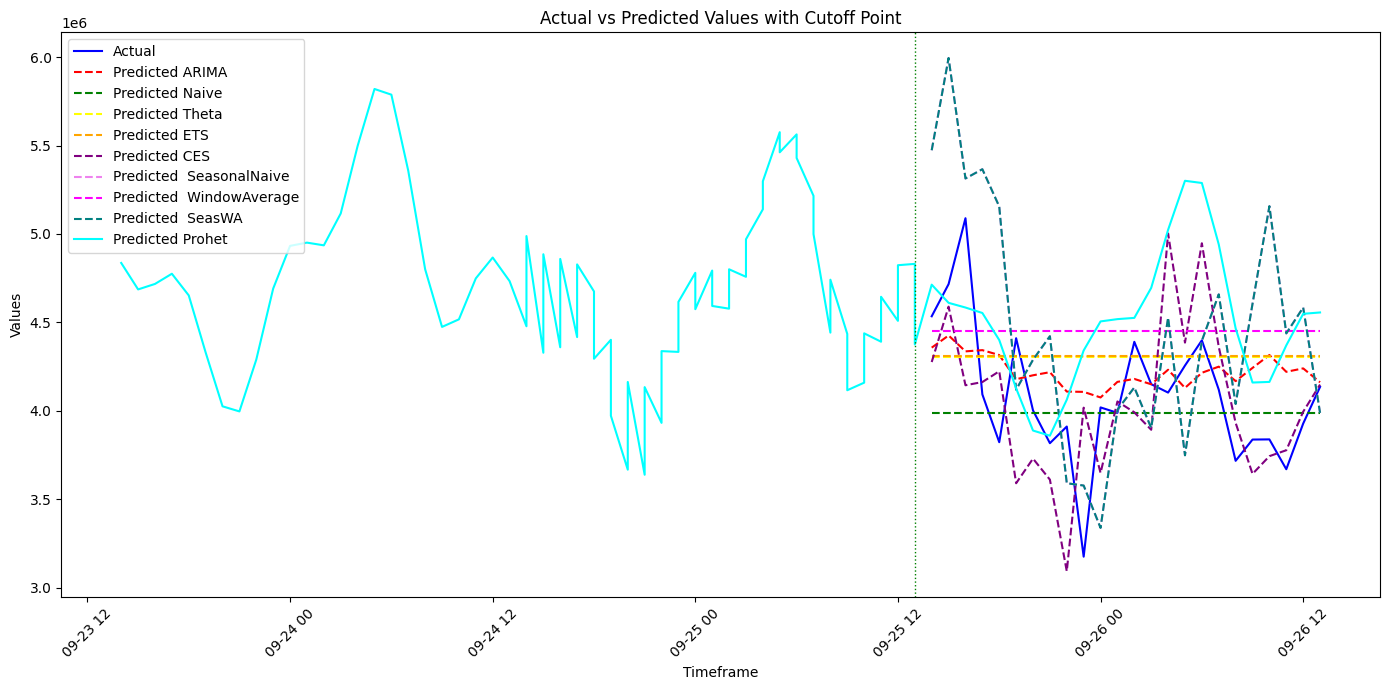

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame
# Plot the actual and predicted values
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoARIMA'], label='Predicted ARIMA', color='red', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['Naive'], label='Predicted Naive', color='green', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoTheta'], label='Predicted Theta', color='yellow', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['AutoETS'], label='Predicted ETS', color='orange', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['CES'], label='Predicted CES', color='purple', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasonalNaive'], label='Predicted  SeasonalNaive', color='violet', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['WindowAverage'], label='Predicted  WindowAverage', color='magenta', linestyle='--')

plt.plot(crossvaldation_df['ds'], crossvaldation_df['SeasWA'], label='Predicted  SeasWA', color='teal', linestyle='--')

plt.plot(df_cv['ds'], df_cv['yhat'], label='Predicted Prohet', color='cyan', linestyle='-')


for cutoff in crossvaldation_df['cutoff'].unique():
    plt.axvline(x=cutoff, color='green', linestyle=':', linewidth=1)

plt.title('Actual vs Predicted Values with Cutoff Point')
plt.xlabel('Timeframe')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [13]:
crossvaldation_df = crossvaldation_df.reset_index()
crossvaldation_df['prophet'] = df_cv['yhat']
crossvaldation_df

,unique_id,ds,cutoff,y,AutoARIMA,AutoTheta,AutoETS,CES,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet
0,VM392_mem,2013-09-25 14:00:00,2013-09-25 13:00:00,4534507.00,4357104.50,4306348.0,4309824.5,4275757.00,5473332.00,4450781.5,5473332.00,3988315.0,4.836013e+06
1,VM392_mem,2013-09-25 15:00:00,2013-09-25 13:00:00,4716259.50,4425932.00,4306348.0,4309824.5,4588914.50,5995056.50,4450781.5,5995056.50,3988315.0,4.686405e+06
2,VM392_mem,2013-09-25 16:00:00,2013-09-25 13:00:00,5089087.00,4336047.00,4306348.0,4309824.5,4144359.50,5313715.00,4450781.5,5313715.00,3988315.0,4.717353e+06
3,VM392_mem,2013-09-25 17:00:00,2013-09-25 13:00:00,4092706.50,4342959.50,4306348.0,4309824.5,4162486.75,5366111.50,4450781.5,5366111.50,3988315.0,4.774974e+06
4,VM392_mem,2013-09-25 18:00:00,2013-09-25 13:00:00,3822407.00,4315143.50,4306348.0,4309824.5,4223410.50,5155264.00,4450781.5,5155264.00,3988315.0,4.652444e+06
5,VM392_mem,2013-09-25 19:00:00,2013-09-25 13:00:00,4410541.50,4178472.00,4306348.0,4309824.5,3590228.00,4119270.75,4450781.5,4119270.75,3988315.0,4.329874e+06
6,VM392_mem,2013-09-25 20:00:00,2013-09-25 13:00:00,4002296.25,4200789.50,4306348.0,4309824.5,3729516.50,4288441.00,4450781.5,4288441.00,3988315.0,4.025291e+06
7,VM392_mem,2013-09-25 21:00:00,2013-09-25 13:00:00,3816814.25,4218382.00,4306348.0,4309824.5,3610742.25,4421793.00,4450781.5,4421793.00,3988315.0,3.996473e+06
8,VM392_mem,2013-09-25 22:00:00,2013-09-25 13:00:00,3910953.50,4108691.25,4306348.0,4309824.5,3092712.75,3590321.75,4450781.5,3590321.75,3988315.0,4.289808e+06
9,VM392_mem,2013-09-25 23:00:00,2013-09-25 13:00:00,3175085.50,4106970.00,4306348.0,4309824.5,4017762.50,3577273.00,4450781.5,3577273.00,3988315.0,4.691118e+06


In [14]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [15]:
evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()

,AutoARIMA,AutoTheta,AutoETS,CES,SeasonalNaive,WindowAverage,SeasWA,Naive,prophet,best_model
unique_id,,,,,,,,,,
VM392_mem,1.378309e+11,1.899304e+11,1.914582e+11,2.071846e+11,4.814824e+11,2.737611e+11,4.814824e+11,1.524205e+11,7.980145e+11,AutoARIMA
